# Feature Importance & Ablation Study: Wine Quality Dataset

**Research Question:** "Which features matter and why? An ablation study on the Wine Quality dataset."

**Authoren:** Katrin Nguyen & Nico Loss

## 1. Setup & Imports <a id='setup'></a>

In [148]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score
)

# Feature selection methods
from sklearn.feature_selection import (
    mutual_info_classif,
    f_classif
)
from sklearn.inspection import permutation_importance

# Report generation
from ydata_profiling import ProfileReport

# For data fetching
from ucimlrepo import fetch_ucirepo

warnings.filterwarnings('ignore')

# Matplotlib inline for Jupyter Notebooks
%matplotlib inline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
TEST_SIZE = 0.20
CV_FOLDS = 5

Path("Reports").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All imports successful")

✓ All imports successful


## 2. Data Loading & Exploration <a id='data-loading'></a>

### 2.1 Load Dataset
Link: https://archive.ics.uci.edu/dataset/186/wine+quality

In [149]:
# Fetch dataset from UCI repository
print("Fetching Wine Quality dataset from UCI repository...")
wine_quality = fetch_ucirepo(id=186)

# Extract features and target
X = wine_quality.data.features
y = wine_quality.data.targets

# Combine for easier manipulation
df = pd.concat([X, y], axis=1)

print(f"\n✓ Dataset loaded successfully")
print(f"  - Shape: {df.shape}")
print(f"  - Features: {X.shape[1]}")
print(f"  - Samples: {len(df)}")

print("\n" + "="*50)
print("VARIABLE INFORMATION")
print("="*50)
print(wine_quality.variables)

Fetching Wine Quality dataset from UCI repository...

✓ Dataset loaded successfully
  - Shape: (6497, 12)
  - Features: 11
  - Samples: 6497

VARIABLE INFORMATION
                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Oth

## 3. Data Preprocessing <a id='preprocessing'></a>

### 3.1 Missing Values Check

In [150]:
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")
print("\n✓ Dataset is clean - no missing values")

Missing Values:
No missing values

✓ Dataset is clean - no missing values


### 3.2 Train/Validation/Test Split

In [151]:
print("\n" + "="*50)
print("TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)")
print("="*50)

# First split: separate test set (20%)
df_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Second split: separate train (60%) and validation (20% of total = 25% of temp)
df_train, df_val = train_test_split(df_temp, test_size=0.25, random_state=42)

print(f"Training set (raw): {len(df_train)} samples")
print(f"Validation set (raw): {len(df_val)} samples")
print(f"Test set (raw): {len(df_test)} samples")


TRAIN-VALIDATION-TEST SPLIT (BEFORE PREPROCESSING)
Training set (raw): 3897 samples
Validation set (raw): 1300 samples
Test set (raw): 1300 samples


### 3.3 Outlier-Behandlung

In [152]:
print("\n" + "="*60)
print("OUTLIER HANDLING")
print("="*60)

# 1. Definieren der Features, die geprüft werden sollen
TARGET_COL = 'quality'
feature_names = [col for col in df_train.columns if col != TARGET_COL]
factor = 3.0

print(f"Berechne Outlier-Grenzen (IQR-Faktor={factor}) aus df_train...")

# 2. Outlier-Grenzen aus den Trainingsdaten berechnen
bounds = {}
for feature in feature_names:
    Q1 = df_train[feature].quantile(0.25)
    Q3 = df_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    bounds[feature] = (lower_bound, upper_bound)

# 3. Funktion, um Zeilen basierend auf den gelernten Grenzen zu entfernen
def remove_outliers_with_bounds(df, bounds_dict):
    df_clean = df.copy()
    # Maske ist initial True für alle Zeilen
    mask = pd.Series(True, index=df_clean.index)

    # Filtere alle Features: Eine Zeile wird entfernt, wenn sie *bei irgendeinem* Feature
    # außerhalb der Grenzen liegt.
    for feature, (lower, upper) in bounds_dict.items():
        # Behalte Zeilen, die INNERHALB der Grenzen liegen (mask & (Bedingung))
        mask = mask & (df_clean[feature] >= lower) & (df_clean[feature] <= upper)

    removed_count = len(df_clean) - mask.sum()
    return df_clean[mask], removed_count

# 4. Wende die gleichen Grenzen auf alle drei Datensätze an
print("\nWende Grenzen auf df_train, df_val und df_test an...")

len_train_orig = len(df_train)
df_train, removed_train = remove_outliers_with_bounds(df_train, bounds)
print(f"  Trainingsset:   {len_train_orig} -> {len(df_train)} (Entfernt: {removed_train})")

len_val_orig = len(df_val)
df_val, removed_val = remove_outliers_with_bounds(df_val, bounds)
print(f"  Validierungsset: {len_val_orig} -> {len(df_val)} (Entfernt: {removed_val})")

len_test_orig = len(df_test)
df_test, removed_test = remove_outliers_with_bounds(df_test, bounds)
print(f"  Testset:       {len_test_orig} -> {len(df_test)} (Entfernt: {removed_test})")

total_orig = len_train_orig + len_val_orig + len_test_orig
total_removed = removed_train + removed_val + removed_test

print(f"\nInsgesamt entfernt: {total_removed} Samples ({(total_removed / total_orig * 100):.2f}%)")


OUTLIER HANDLING
Berechne Outlier-Grenzen (IQR-Faktor=3.0) aus df_train...

Wende Grenzen auf df_train, df_val und df_test an...
  Trainingsset:   3897 -> 3737 (Entfernt: 160)
  Validierungsset: 1300 -> 1235 (Entfernt: 65)
  Testset:       1300 -> 1223 (Entfernt: 77)

Insgesamt entfernt: 302 Samples (4.65%)


### 3.4 Prepare Feature and Target

In [153]:
print("\n" + "="*50)
print("FEATURE AND TARGET PREPARATION")
print("="*50)

# Zielvariable (Target)
TARGET_COL = 'quality'

# Extract features and targets
X_train = df_train.drop(TARGET_COL, axis=1)
y_train = df_train['quality']

X_val = df_val.drop(TARGET_COL, axis=1)
y_val = df_val['quality']

X_test = df_test.drop(TARGET_COL, axis=1)
y_test = df_test['quality']

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


FEATURE AND TARGET PREPARATION
X_train shape: (3737, 11)
X_val shape: (1235, 11)
X_test shape: (1223, 11)


### 3.5 Feature Scaling

In [154]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Feature Scaling Complete (StandardScaler)")
print(f"  Train mean: {X_train_scaled.mean().mean():.6f}")
print(f"  Train std:  {X_train_scaled.std().mean():.6f}")

Feature Scaling Complete (StandardScaler)
  Train mean: 0.000000
  Train std:  1.000134


## 4.0 Explorative Data Analysis

In [155]:
print("First 5 rows:")
display(df_train.head())

print("\nDataset Statistics:")
display(df_train.describe())

print("\nData Types and Missing Values:")
info_df = pd.DataFrame({
    'Column': df_train.columns,
    'Type': df_train.dtypes,
    'Non-Null': df_train.count(),
    'Null': df_train.isnull().sum(),
    'Null %': (df_train.isnull().sum() / len(df_train) * 100).round(2)
})
display(info_df)

First 5 rows:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
5130,6.4,0.28,0.44,7.1,0.048,49.0,179.0,0.99528,3.15,0.48,9.2,5
3064,7.0,0.20,0.74,0.8,0.044,19.0,163.0,0.99310,3.46,0.53,10.2,5
4040,7.2,0.20,0.28,1.6,0.028,13.0,168.0,0.99203,3.17,1.06,11.5,6
2950,6.5,0.37,0.33,3.9,0.027,40.0,130.0,0.99060,3.28,0.39,12.7,7
4221,6.6,0.26,0.21,2.9,0.026,48.0,126.0,0.99089,3.22,0.38,11.3,7



Dataset Statistics:


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000,3737.000000
mean,7.113085,0.327372,0.315510,5.489765,0.051651,30.926813,117.682901,0.994552,3.219318,0.523803,10.496178,5.822585
std,1.101595,0.151512,0.135174,4.710242,0.020425,16.972512,54.800943,0.002878,0.156855,0.131249,1.191544,0.866547
min,3.900000,0.080000,0.000000,0.600000,0.009000,2.000000,6.000000,0.987110,2.740000,0.220000,8.000000,3.000000
25%,6.400000,0.220000,0.250000,1.800000,0.038000,18.000000,83.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,6.900000,0.280000,0.310000,3.200000,0.046000,29.000000,119.000000,0.994710,3.210000,0.500000,10.300000,6.000000
75%,7.600000,0.390000,0.390000,8.250000,0.060000,42.000000,157.000000,0.996800,3.320000,0.600000,11.300000,6.000000
max,11.600000,0.935000,0.800000,22.000000,0.142000,108.000000,344.000000,1.002600,3.900000,1.100000,14.200000,9.000000



Data Types and Missing Values:


,Column,Type,Non-Null,Null,Null %
fixed_acidity,fixed_acidity,float64,3737,0,0.0
volatile_acidity,volatile_acidity,float64,3737,0,0.0
citric_acid,citric_acid,float64,3737,0,0.0
residual_sugar,residual_sugar,float64,3737,0,0.0
chlorides,chlorides,float64,3737,0,0.0
free_sulfur_dioxide,free_sulfur_dioxide,float64,3737,0,0.0
total_sulfur_dioxide,total_sulfur_dioxide,float64,3737,0,0.0
density,density,float64,3737,0,0.0
pH,pH,float64,3737,0,0.0
sulphates,sulphates,float64,3737,0,0.0


### 4.3 Report Generation

In [156]:
profile = ProfileReport(df_train, title="Wine Quality Dataset Report", explorative=True)
profile.to_file("Reports/wine_quality_ydata_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 48.13it/s]


### 4.4 Correlation Analysis

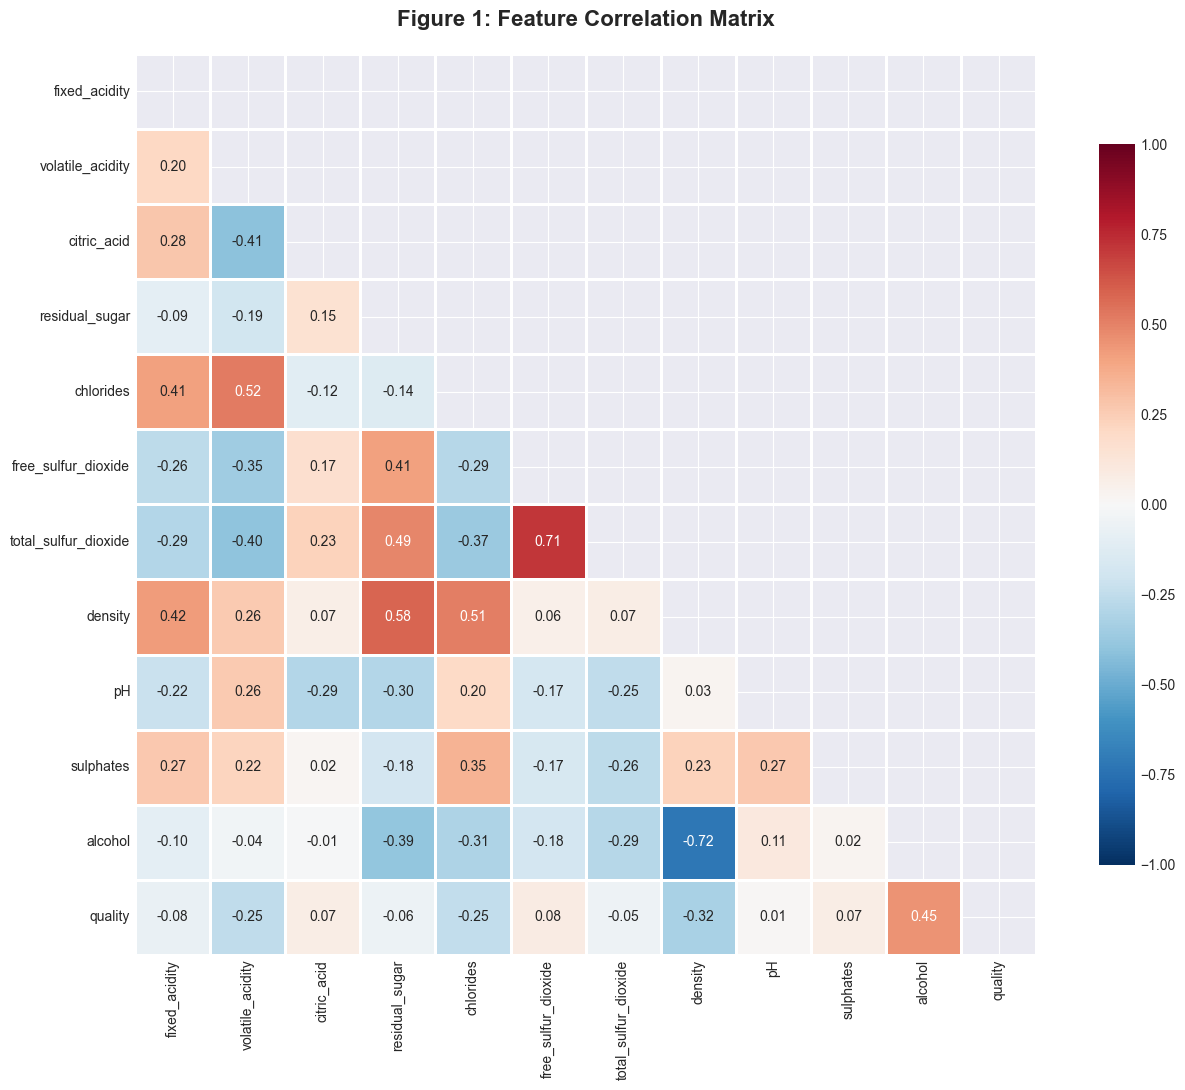


Correlations with Quality:
alcohol                 0.448206
free_sulfur_dioxide     0.082524
citric_acid             0.074136
sulphates               0.073407
pH                      0.014331
total_sulfur_dioxide   -0.048160
residual_sugar         -0.057239
fixed_acidity          -0.076164
chlorides              -0.245762
volatile_acidity       -0.250419
density                -0.323786
Name: quality, dtype: float64


In [157]:
correlation_matrix = df_train.corr()

plt.figure(figsize=(14, 11))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Figure 1: Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/figure1_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelations with Quality:")
print(correlation_matrix['quality'].drop('quality').sort_values(ascending=False))

## 5. Baseline Model

### 5.1 Train and Evaluate Baseline Model

In [158]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

sampling_strategy = {
    3: 50,  # Klasse 3 auf 50 Elemente anheben
    9: 50,  # Klasse 9 auf 50 Elemente anheben
}

sampler = SMOTEENN(random_state=RANDOM_STATE,
                   sampling_strategy=sampling_strategy,
                   smote=SMOTE(random_state=RANDOM_STATE, k_neighbors=3))

In [159]:
param_grid = {
    'max_depth': [5, 6, 7],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [8, 10, 12, 14],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [80, 100, 120]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Erstellen der imbalanced-learn Pipeline
pipe = ImbPipeline([
    ('sampler', sampler),
    ('rf', rf)
])

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=CV_FOLDS, n_jobs=-1, verbose=2, return_train_score=True)

# 3. Modell trainieren
grid_search.fit(X_train_scaled, y_train)

print(f"\nBeste Parameter nach GridSearchCV: {grid_search.best_params_}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Beste Parameter nach GridSearchCV: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 100}


In [160]:
cv_results = pd.DataFrame(grid_search.cv_results_)

# 1. Die Spalten auswählen, die uns interessieren
relevant_cols = [
    'params',
    'mean_train_score',
    'mean_test_score',
    'rank_test_score'
]
# .copy() verhindert eine 'SettingWithCopyWarning'
results_df = cv_results[relevant_cols].copy()

# 2. Den "Gap" (Overfitting) als neue Spalte berechnen
results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']

# 3. Ergebnisse anzeigen
print("\n" + "="*50)
print("Analyse des Train-Test-Gaps (Overfitting)")
print("="*50)

# Zeigt die Top-Performer, aber vielleicht mit hohem Gap
print("\n--- Top 5 Modelle (sortiert nach bestem Test-Score) ---")
print(results_df.sort_values(by='rank_test_score').head())

# Zeigt die Modelle, die am besten generalisieren (kleinstes Overfitting)
print("\n--- Top 5 Modelle (sortiert nach geringstem Gap) ---")
print(results_df.sort_values(by='gap').head())


Analyse des Train-Test-Gaps (Overfitting)

--- Top 5 Modelle (sortiert nach bestem Test-Score) ---
                                                params  mean_train_score  \
145  {'max_depth': 7, 'max_features': 'sqrt', 'min_...          0.671126   
148  {'max_depth': 7, 'max_features': 'sqrt', 'min_...          0.671126   
184  {'max_depth': 7, 'max_features': 'log2', 'min_...          0.671126   
181  {'max_depth': 7, 'max_features': 'log2', 'min_...          0.671126   
182  {'max_depth': 7, 'max_features': 'log2', 'min_...          0.670925   

     mean_test_score  rank_test_score       gap  
145         0.582284                1  0.088842  
148         0.582284                1  0.088842  
184         0.582284                1  0.088842  
181         0.582284                1  0.088842  
182         0.581750                5  0.089175  

--- Top 5 Modelle (sortiert nach geringstem Gap) ---
                                               params  mean_train_score  \
31  {'max_dept

In [161]:
baseline_model = RandomForestClassifier(**grid_search.best_params_)
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train_scaled)
y_val_pred = baseline_model.predict(X_val_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

# Metrics
baseline_metrics = {
    'Training Accuracy': accuracy_score(y_train, y_train_pred),
    'Validation Accuracy': accuracy_score(y_val, y_val_pred),
    'Test Accuracy': accuracy_score(y_test, y_test_pred),
    'Validation F1': f1_score(y_val, y_val_pred, average='weighted'),
    'Validation Precision': precision_score(y_val, y_val_pred, average='weighted', zero_division=0),
    'Validation Recall': recall_score(y_val, y_val_pred, average='weighted'),
    'Test F1': f1_score(y_test, y_test_pred, average='weighted'),
    'Test Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
    'Test Recall': recall_score(y_test, y_test_pred, average='weighted')
}

# Cross-validation
cv_scores = cross_val_score(baseline_model, X_train_scaled, y_train, 
                            cv=CV_FOLDS, scoring='accuracy')
baseline_metrics['CV Mean'] = cv_scores.mean()
baseline_metrics['CV Std'] = cv_scores.std()

print("\n" + "="*70)
print("TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)")
print("="*70)
for metric, value in baseline_metrics.items():
    print(f"{metric:25s}: {value:.4f}")

# Check overfitting
train_val_gap = baseline_metrics['Training Accuracy'] - baseline_metrics['Validation Accuracy']
print(f"\n{'='*70}")
print(f"OVERFITTING CHECK")
print(f"{'='*70}")
print(f"Train-Validation Gap: {train_val_gap:.4f} ({train_val_gap*100:.2f}%)")

if train_val_gap < 0.05:
    print("✓✓ EXCELLENT: Gap < 5% - No overfitting!")
elif train_val_gap < 0.10:
    print("✓ GOOD: Gap < 10% - Acceptable generalization")
elif train_val_gap < 0.15:
    print("⚠ WARNING: Gap 10-15% - Slight overfitting")
else:
    print("❌ PROBLEM: Gap > 15% - Significant overfitting")

# Save
pd.DataFrame([baseline_metrics]).to_csv('figures/table2_baseline_performance.csv', index=False)
print("\n✓ Saved to figures/table2_baseline_performance.csv")


TABLE 2: BASELINE PERFORMANCE (REGULARIZED MODEL)
Training Accuracy        : 0.6620
Validation Accuracy      : 0.5968
Test Accuracy            : 0.5805
Validation F1            : 0.5583
Validation Precision     : 0.5432
Validation Recall        : 0.5968
Test F1                  : 0.5495
Test Precision           : 0.5473
Test Recall              : 0.5805
CV Mean                  : 0.5743
CV Std                   : 0.0190

OVERFITTING CHECK
Train-Validation Gap: 0.0653 (6.53%)
✓ GOOD: Gap < 10% - Acceptable generalization

✓ Saved to figures/table2_baseline_performance.csv


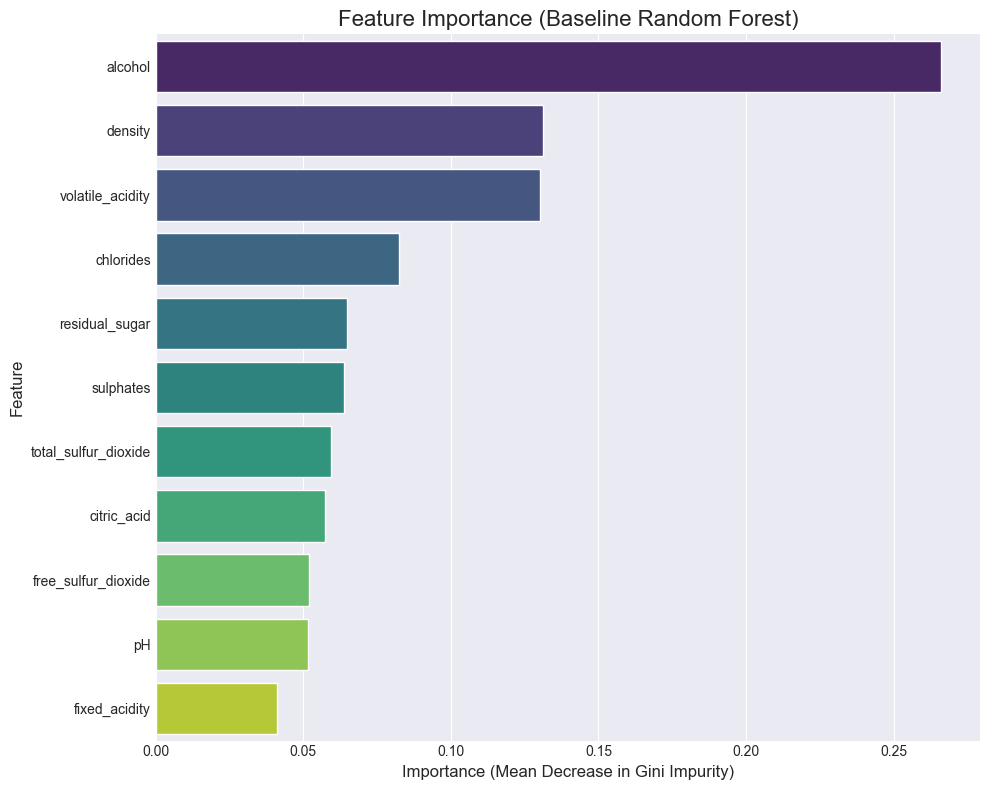


Top 11 Wichtigste Features:
                 Feature  Importance
10               alcohol    0.265964
7                density    0.131350
1       volatile_acidity    0.130091
4              chlorides    0.082270
3         residual_sugar    0.064768
9              sulphates    0.063835
6   total_sulfur_dioxide    0.059535
2            citric_acid    0.057499
5    free_sulfur_dioxide    0.051997
8                     pH    0.051648
0          fixed_acidity    0.041044


<Figure size 640x480 with 0 Axes>

In [162]:
# 1. Feature Importance extrahieren
importances = baseline_model.feature_importances_

# 2. Feature-Namen holen
feature_names = X_train.columns

# 3. In einem DataFrame für einfaches Plotten kombinieren
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Nach Wichtigkeit sortieren
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Visualisieren
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='viridis'
)

plt.title('Feature Importance (Baseline Random Forest)', fontsize=16)
plt.xlabel('Importance (Mean Decrease in Gini Impurity)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

plt.savefig('figures/feature_importance_baselineRF.png', dpi=300, bbox_inches='tight')

print("\nTop 11 Wichtigste Features:")
print(feature_importance_df.head(11))

## 6. Feature Selection Methods <a id='feature-selection'></a>

In [163]:
feature_importance_results = {}

# 1. Correlation
correlation_scores = X_train_scaled.corrwith(y_train).abs()
feature_importance_results['Correlation'] = correlation_scores

# 2. Mutual Information
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)
feature_importance_results['Mutual Information'] = pd.Series(mi_scores, index=X_train.columns)

# 3. ANOVA F-test
f_scores, _ = f_classif(X_train_scaled, y_train)
feature_importance_results['ANOVA F-Score'] = pd.Series(f_scores, index=X_train.columns)

# 4. Tree Importance
tree_importance = pd.Series(baseline_model.feature_importances_, index=X_train.columns)
feature_importance_results['Tree Importance'] = tree_importance

# 5. Permutation Importance
perm_importance = permutation_importance(
    baseline_model, X_val_scaled, y_val,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
perm_scores = pd.Series(perm_importance.importances_mean, index=X_train.columns)
feature_importance_results['Permutation Importance'] = perm_scores

print("✓ Feature Selection Methods Complete (6 methods)")

✓ Feature Selection Methods Complete (6 methods)


In [164]:
# Compile and normalize
importance_df = pd.DataFrame(feature_importance_results)
importance_df_norm = importance_df.copy()

for col in importance_df_norm.columns:
    importance_df_norm[col] = (importance_df_norm[col] - importance_df_norm[col].min()) / \
                               (importance_df_norm[col].max() - importance_df_norm[col].min())

importance_df_norm['Average Score'] = importance_df_norm.mean(axis=1)
importance_df_norm['Rank'] = importance_df_norm['Average Score'].rank(ascending=False)
importance_df_norm = importance_df_norm.sort_values('Average Score', ascending=False)

print("\n" + "="*80)
print("TABLE 3: FEATURE IMPORTANCE RANKINGS")
print("="*80)
display(importance_df_norm.round(4))

importance_df_norm.to_csv('figures/table3_feature_importance_rankings.csv')
print("\n✓ Saved to figures/table3_feature_importance_rankings.csv")


TABLE 3: FEATURE IMPORTANCE RANKINGS


,Correlation,Mutual Information,ANOVA F-Score,Tree Importance,Permutation Importance,Average Score,Rank
alcohol,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0
density,0.7132,0.9346,0.4732,0.4015,0.1405,0.5326,2.0
volatile_acidity,0.5441,0.2610,0.2577,0.3959,0.7299,0.4377,3.0
chlorides,0.5334,0.4484,0.2458,0.1833,0.0945,0.3011,4.0
total_sulfur_dioxide,0.0780,0.5606,0.0319,0.0822,0.1390,0.1783,5.0
residual_sugar,0.0989,0.4006,0.0317,0.1055,0.1194,0.1512,6.0
free_sulfur_dioxide,0.1572,0.2592,0.0574,0.0487,0.1116,0.1268,7.0
sulphates,0.1362,0.1771,0.0212,0.1013,0.1421,0.1156,8.0
citric_acid,0.1378,0.2922,0.0248,0.0732,0.0406,0.1137,9.0
fixed_acidity,0.1425,0.1133,0.0182,0.0000,0.0000,0.0548,10.0



✓ Saved to figures/table3_feature_importance_rankings.csv


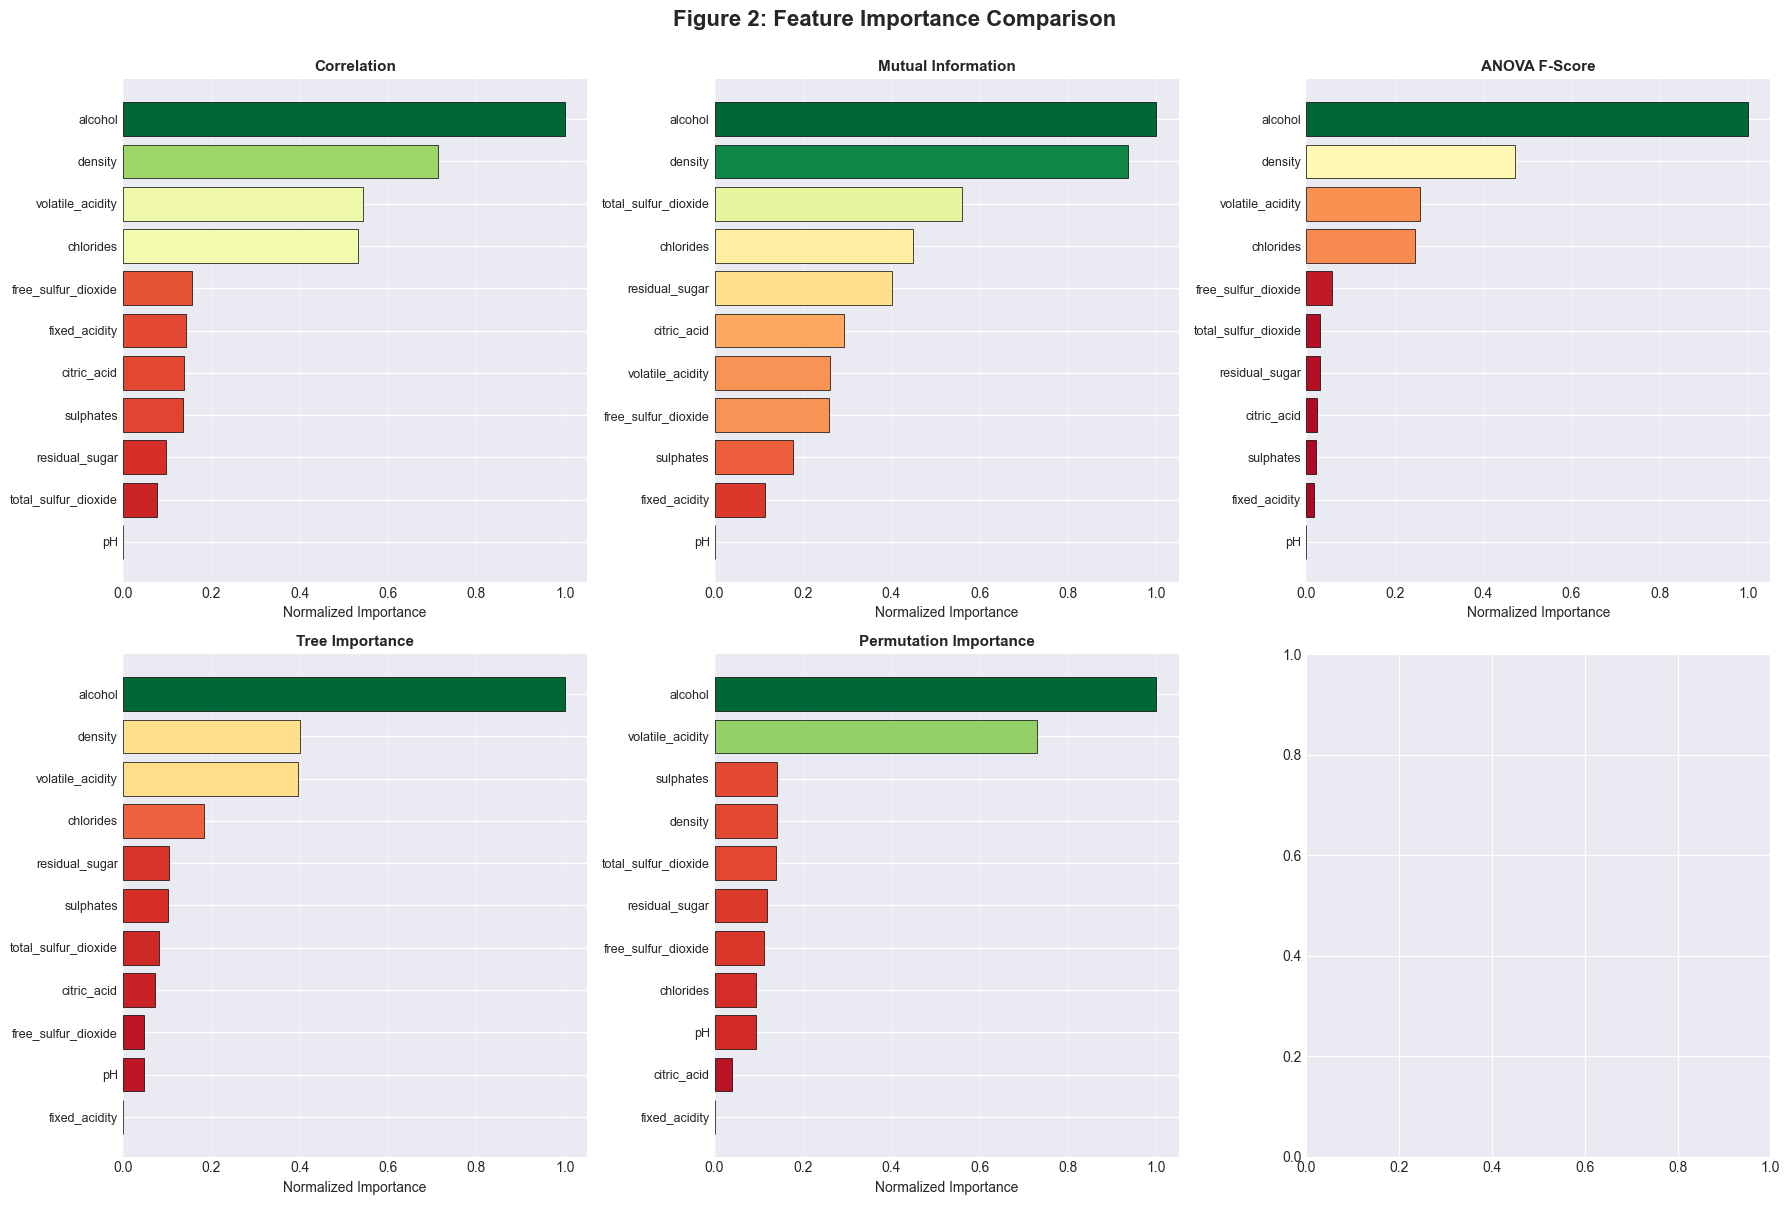

✓ Figure 2 saved


In [165]:
# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

methods = ['Correlation', 'Mutual Information', 'ANOVA F-Score', 
           'Tree Importance', 'Permutation Importance']

for idx, method in enumerate(methods):
    data = importance_df_norm[method].sort_values(ascending=True)
    colors = plt.cm.RdYlGn(data / data.max())
    axes[idx].barh(range(len(data)), data.values, color=colors, edgecolor='black', linewidth=0.5)
    axes[idx].set_yticks(range(len(data)))
    axes[idx].set_yticklabels(data.index, fontsize=9)
    axes[idx].set_xlabel('Normalized Importance', fontsize=10)
    axes[idx].set_title(method, fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Figure 2: Feature Importance Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('figures/figure2_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved")

## 7. Ablation Study <a id='ablation'></a>

### 7.1 Individual Feature Ablation

In [166]:
ablation_results = []

print("Running Individual Feature Ablation (using VALIDATION set)...\n")

for feature in X_train.columns:
    features_subset = [f for f in X_train.columns if f != feature]
    X_train_ablated = X_train_scaled[features_subset]
    X_val_ablated = X_val_scaled[features_subset]
    
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train_ablated, y_train)
    
    y_val_pred = model.predict(X_val_ablated)
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_drop = baseline_metrics['Validation Accuracy'] - accuracy
    
    ablation_results.append({
        'Feature Removed': feature,
        'Validation Accuracy': accuracy,
        'Accuracy Drop': accuracy_drop,
        'Drop %': accuracy_drop / baseline_metrics['Validation Accuracy'] * 100
    })
    
    print(f"  Removed '{feature}': Acc={accuracy:.4f}, Drop={accuracy_drop:+.4f}")

ablation_df = pd.DataFrame(ablation_results).sort_values('Accuracy Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS")
print("="*80)
display(ablation_df)

ablation_df.to_csv('figures/table4_ablation_results.csv', index=False)
print("\n✓ Saved to figures/table4_ablation_results.csv")

Running Individual Feature Ablation (using VALIDATION set)...

  Removed 'fixed_acidity': Acc=0.5919, Drop=+0.0049
  Removed 'volatile_acidity': Acc=0.5741, Drop=+0.0227
  Removed 'citric_acid': Acc=0.6008, Drop=-0.0040
  Removed 'residual_sugar': Acc=0.5968, Drop=+0.0000
  Removed 'chlorides': Acc=0.5943, Drop=+0.0024
  Removed 'free_sulfur_dioxide': Acc=0.5806, Drop=+0.0162
  Removed 'total_sulfur_dioxide': Acc=0.5960, Drop=+0.0008
  Removed 'density': Acc=0.5935, Drop=+0.0032
  Removed 'pH': Acc=0.5935, Drop=+0.0032
  Removed 'sulphates': Acc=0.5757, Drop=+0.0211
  Removed 'alcohol': Acc=0.5846, Drop=+0.0121

TABLE 4: INDIVIDUAL FEATURE ABLATION RESULTS


,Feature Removed,Validation Accuracy,Accuracy Drop,Drop %
1,volatile_acidity,0.574089,0.022672,3.799186
9,sulphates,0.575709,0.021053,3.527815
5,free_sulfur_dioxide,0.580567,0.016194,2.713704
10,alcohol,0.584615,0.012146,2.035278
0,fixed_acidity,0.591903,0.004858,0.814111
7,density,0.593522,0.003239,0.542741
8,pH,0.593522,0.003239,0.542741
4,chlorides,0.594332,0.002429,0.407056
6,total_sulfur_dioxide,0.595951,0.000810,0.135685
3,residual_sugar,0.596761,0.000000,0.000000



✓ Saved to figures/table4_ablation_results.csv


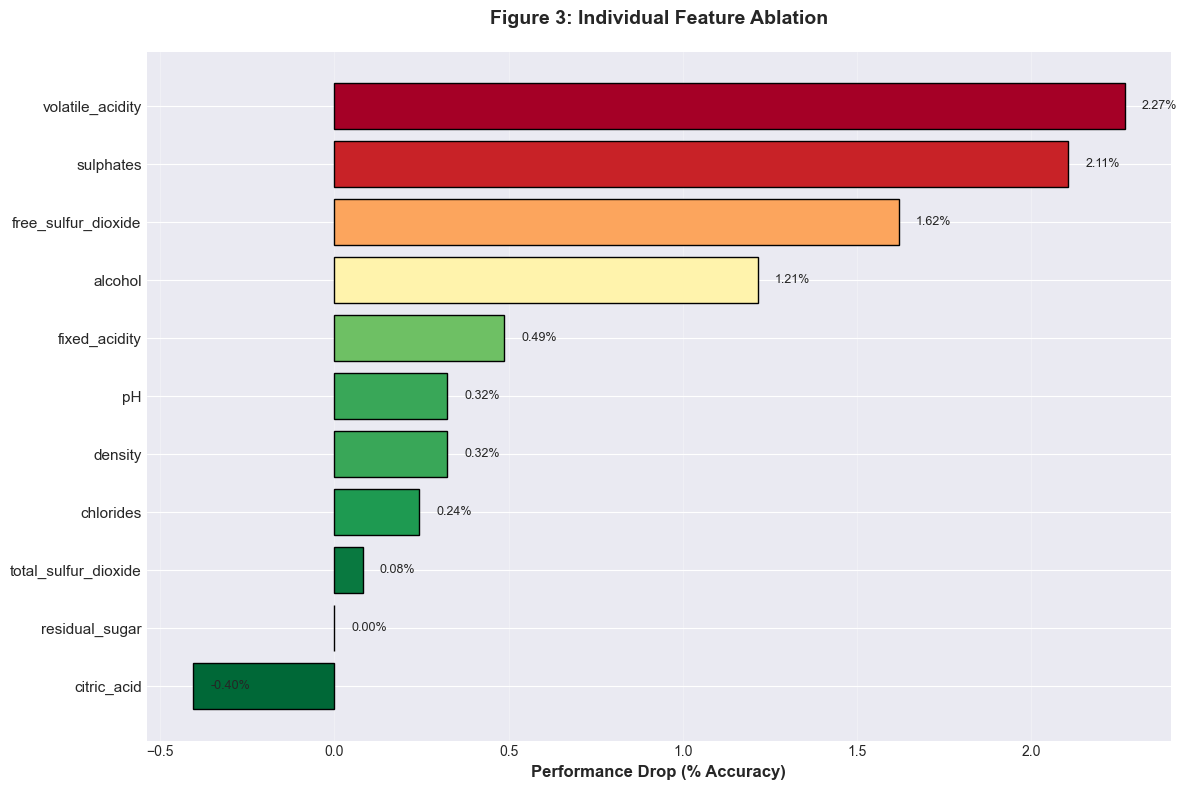

✓ Figure 3 saved


In [167]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
plot_data = ablation_df.sort_values('Accuracy Drop', ascending=True)
colors = plt.cm.RdYlGn_r(plot_data['Accuracy Drop'] / plot_data['Accuracy Drop'].max())

ax.barh(range(len(plot_data)), plot_data['Accuracy Drop'].values * 100,
        color=colors, edgecolor='black', linewidth=1)
ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels(plot_data['Feature Removed'], fontsize=11)
ax.set_xlabel('Performance Drop (% Accuracy)', fontsize=12, fontweight='bold')
ax.set_title('Figure 3: Individual Feature Ablation', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data.iterrows()):
    value = row['Accuracy Drop'] * 100
    ax.text(value + 0.05, i, f"{value:.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure3_individual_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved")

### 7.2 Cumulative Feature Addition

In [168]:
feature_order = importance_df_norm['Average Score'].sort_values(ascending=False).index.tolist()
cumulative_results = []

print("Running Cumulative Feature Addition...\n")

for i in range(1, len(feature_order) + 1):
    selected_features = feature_order[:i]
    X_train_subset = X_train_scaled[selected_features]
    X_val_subset = X_val_scaled[selected_features]
    
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train_subset, y_train)
    
    y_val_pred = model.predict(X_val_subset)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    cv_scores = cross_val_score(model, X_train_subset, y_train, cv=CV_FOLDS, scoring='accuracy')
    
    cumulative_results.append({
        'Num Features': i,
        'Validation Accuracy': accuracy,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    
    print(f"Top {i:2d}: Val Acc = {accuracy:.4f}")

cumulative_df = pd.DataFrame(cumulative_results)
print(f"\nPeak: {cumulative_df.loc[cumulative_df['Validation Accuracy'].idxmax(), 'Num Features']} features")

Running Cumulative Feature Addition...

Top  1: Val Acc = 0.5045
Top  2: Val Acc = 0.5206
Top  3: Val Acc = 0.5514
Top  4: Val Acc = 0.5619
Top  5: Val Acc = 0.5814
Top  6: Val Acc = 0.5838
Top  7: Val Acc = 0.5854
Top  8: Val Acc = 0.5911
Top  9: Val Acc = 0.5911
Top 10: Val Acc = 0.5903
Top 11: Val Acc = 0.5992

Peak: 11 features


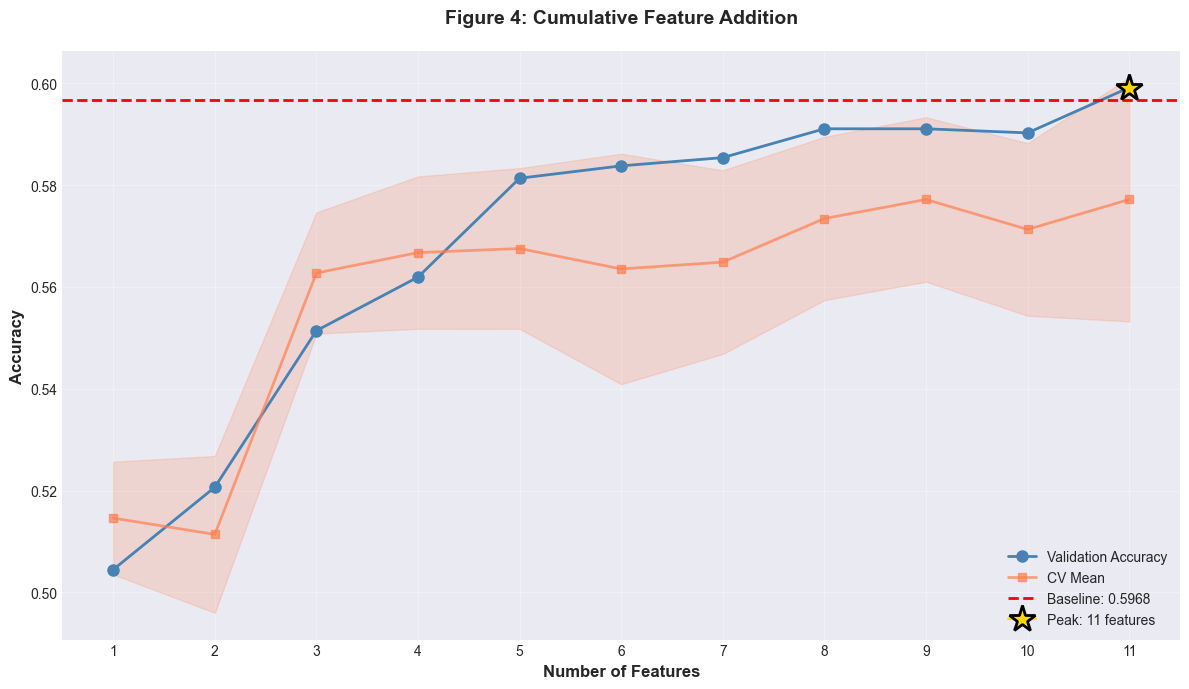

✓ Figure 4 saved


In [169]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(cumulative_df['Num Features'], cumulative_df['Validation Accuracy'], 
        marker='o', linewidth=2, markersize=8, color='steelblue', label='Validation Accuracy')
ax.plot(cumulative_df['Num Features'], cumulative_df['CV Mean'], 
        marker='s', linewidth=2, markersize=6, color='coral', label='CV Mean', alpha=0.7)

ax.fill_between(cumulative_df['Num Features'], 
                cumulative_df['CV Mean'] - cumulative_df['CV Std'],
                cumulative_df['CV Mean'] + cumulative_df['CV Std'],
                alpha=0.2, color='coral')

ax.axhline(y=baseline_metrics['Validation Accuracy'], color='red', linestyle='--', 
           linewidth=2, label=f"Baseline: {baseline_metrics['Validation Accuracy']:.4f}")

max_idx = cumulative_df['Validation Accuracy'].idxmax()
ax.plot(cumulative_df.loc[max_idx, 'Num Features'], 
        cumulative_df.loc[max_idx, 'Validation Accuracy'],
        marker='*', markersize=20, color='gold', 
        markeredgecolor='black', markeredgewidth=2,
        label=f"Peak: {cumulative_df.loc[max_idx, 'Num Features']} features")

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Figure 4: Cumulative Feature Addition', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, len(feature_order) + 1))

plt.tight_layout()
plt.savefig('figures/figure4_cumulative_addition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved")

### 7.3 Feature Group Ablation

Running Feature Group Ablation (using CV on Training set)...\n
Baseline CV Accuracy (Alle Features): 0.5743\n
  Removed 'acidity' (4 features): New CV Acc=0.5550, Drop=+0.0193
  Removed 'sulfur' (3 features): New CV Acc=0.5670, Drop=+0.0072
  Removed 'content' (3 features): New CV Acc=0.5577, Drop=+0.0166
  Removed 'physical' (1 features): New CV Acc=0.5801, Drop=-0.0059

TABLE 6: FEATURE GROUP ABLATION RESULTS (Sorted by Drop)


,Group Removed,Num Features Removed,CV Accuracy (Ablated),Performance Drop
0,acidity,4,0.554983,0.019271
2,content,3,0.557670,0.016584
1,sulfur,3,0.567028,0.007226
3,physical,1,0.580145,-0.005891



✓ Saved to figures/table6_group_ablation_results.csv


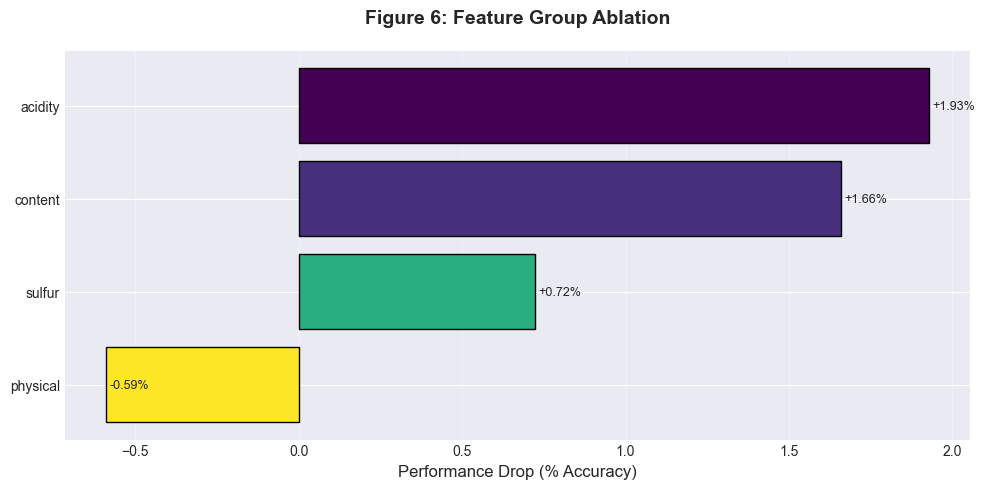


✓ Figure 6 saved


In [170]:
# --- 7.3 Feature Group Ablation ---

print("Running Feature Group Ablation (using CV on Training set)...\\n")

# 1. Feature-Gruppen definieren (basierend auf den Spaltennamen)
feature_groups = {
    'acidity': ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'pH'],
    'sulfur': ['free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulphates'],
    'content': ['residual_sugar', 'chlorides', 'alcohol'],
    'physical': ['density']
}

# 2. Baseline-Score aus Zelle 60 abrufen (CV Mean ist der korrekte Vergleichswert)
baseline_cv_score = baseline_metrics['CV Mean']
print(f"Baseline CV Accuracy (Alle Features): {baseline_cv_score:.4f}\\n")

group_ablation_results = []

# 3. Ablation Study für Gruppen durchführen
for group_name, group_features in feature_groups.items():

    # WICHTIG: Skalierte Daten verwenden (X_train_scaled)
    X_train_ablated = X_train_scaled.drop(columns=group_features)

    # Verwenden Sie das optimierte baseline_model und die CV_FOLDS Variable
    scores = cross_val_score(baseline_model,
                             X_train_ablated,
                             y_train,
                             cv=CV_FOLDS,
                             scoring='accuracy')

    current_score = scores.mean()
    performance_drop = baseline_cv_score - current_score

    group_ablation_results.append({
        'Group Removed': group_name,
        'Num Features Removed': len(group_features),
        'CV Accuracy (Ablated)': current_score,
        'Performance Drop': performance_drop
    })

    print(f"  Removed '{group_name}' ({len(group_features)} features): New CV Acc={current_score:.4f}, Drop={performance_drop:+.4f}")

# 4. Ergebnisse anzeigen und speichern (wird Tabelle 6)
group_ablation_df = pd.DataFrame(group_ablation_results).sort_values('Performance Drop', ascending=False)

print("\n" + "="*80)
print("TABLE 6: FEATURE GROUP ABLATION RESULTS (Sorted by Drop)")
print("="*80)
display(group_ablation_df)

group_ablation_df.to_csv('figures/table6_group_ablation_results.csv', index=False)
print("\n✓ Saved to figures/table6_group_ablation_results.csv")

# 5. Visualisierung (wird Abbildung 6)
fig, ax = plt.subplots(figsize=(10, 5))
plot_data_group = group_ablation_df.sort_values('Performance Drop', ascending=True)

# Performance-Abfall farblich kodieren
colors = plt.cm.viridis_r(plot_data_group['Performance Drop'] / plot_data_group['Performance Drop'].max())

ax.barh(plot_data_group['Group Removed'], plot_data_group['Performance Drop'] * 100,
        color=colors, edgecolor='black', linewidth=1)
ax.set_xlabel('Performance Drop (% Accuracy)', fontsize=12)
ax.set_title('Figure 6: Feature Group Ablation', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(plot_data_group.iterrows()):
    value = row['Performance Drop'] * 100
    ax.text(value + 0.01, i, f"{value:+.2f}%", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/figure6_group_ablation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure 6 saved")

### 7.4 Top-K Feature Selection

In [171]:
k_values = [3, 5, 7, 9, 11]
topk_results = []

print("Testing Top-K Feature Selection...\n")

for k in k_values:
    top_features = feature_order[:k]
    X_train_k = X_train_scaled[top_features]
    X_val_k = X_val_scaled[top_features]
    
    model = RandomForestClassifier(**grid_search.best_params_)
    model.fit(X_train_k, y_train)
    
    y_val_pred = model.predict(X_val_k)
    accuracy = accuracy_score(y_val, y_val_pred)
    
    complexity_reduction = (1 - k / len(feature_order)) * 100
    performance_retention = (accuracy / baseline_metrics['Validation Accuracy']) * 100
    
    topk_results.append({
        'K': k,
        'Validation Accuracy': accuracy,
        'Complexity Reduction %': complexity_reduction,
        'Performance Retention %': performance_retention
    })
    
    print(f"Top-{k}: Acc={accuracy:.4f}, Retention={performance_retention:.1f}%")

topk_df = pd.DataFrame(topk_results)

print("\n" + "="*80)
print("TABLE 5: TOP-K PERFORMANCE")
print("="*80)
display(topk_df)

topk_df.to_csv('figures/table5_topk_performance.csv', index=False)
print("\n✓ Saved to figures/table5_topk_performance.csv")

Testing Top-K Feature Selection...

Top-3: Acc=0.5628, Retention=94.3%
Top-5: Acc=0.5830, Retention=97.7%
Top-7: Acc=0.5919, Retention=99.2%
Top-9: Acc=0.5935, Retention=99.5%
Top-11: Acc=0.6057, Retention=101.5%

TABLE 5: TOP-K PERFORMANCE


,K,Validation Accuracy,Complexity Reduction %,Performance Retention %
0,3,0.562753,72.727273,94.301221
1,5,0.582996,54.545455,97.693351
2,7,0.591903,36.363636,99.185889
3,9,0.593522,18.181818,99.457259
4,11,0.605668,0.000000,101.492537



✓ Saved to figures/table5_topk_performance.csv


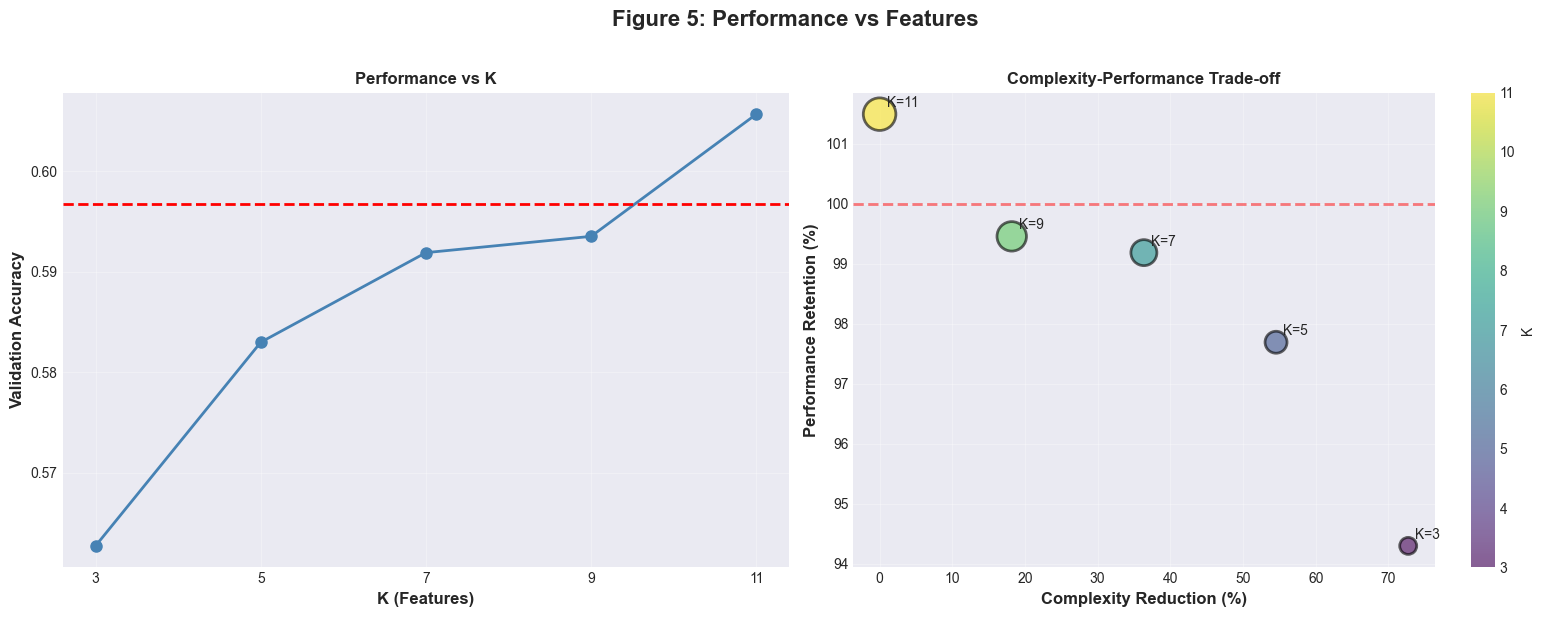

✓ Figure 5 saved


In [172]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(topk_df['K'], topk_df['Validation Accuracy'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(y=baseline_metrics['Validation Accuracy'], color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('K (Features)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Performance vs K', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(topk_df['K'])

scatter = axes[1].scatter(topk_df['Complexity Reduction %'], 
                          topk_df['Performance Retention %'],
                          s=topk_df['K']*50, alpha=0.6, c=topk_df['K'], 
                          cmap='viridis', edgecolors='black', linewidth=2)

for _, row in topk_df.iterrows():
    axes[1].annotate(f"K={int(row['K'])}", 
                     xy=(row['Complexity Reduction %'], row['Performance Retention %']),
                     xytext=(5, 5), textcoords='offset points')

axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('Complexity Reduction (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Performance Retention (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Complexity-Performance Trade-off', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[1], label='K')
plt.suptitle('Figure 5: Performance vs Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/figure5_performance_vs_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure 5 saved")

### 7.4 Final Test Set Evaluation

In [173]:
print("="*80)
print("FINAL TEST SET EVALUATION (Unbiased)")
print("="*80)

optimal_k = cumulative_df.loc[cumulative_df['Validation Accuracy'].idxmax(), 'Num Features']
optimal_features = feature_order[:optimal_k]

print(f"\nOptimal: {optimal_k} features - {', '.join(optimal_features)}\n")

test_evaluations = []

# 1. Baseline (all features)
test_evaluations.append({
    'Configuration': 'All Features',
    'Num Features': 11,
    'Test Accuracy': baseline_metrics['Test Accuracy'],
    'Test F1': baseline_metrics['Test F1']
})

# 2. Optimal subset
model_optimal = RandomForestClassifier(**grid_search.best_params_)
model_optimal.fit(X_train_scaled[optimal_features], y_train)
y_test_pred_opt = model_optimal.predict(X_test_scaled[optimal_features])

test_evaluations.append({
    'Configuration': f'Optimal ({optimal_k})',
    'Num Features': optimal_k,
    'Test Accuracy': accuracy_score(y_test, y_test_pred_opt),
    'Test F1': f1_score(y_test, y_test_pred_opt, average='weighted')
})

# 3. Top-5
model_top5 = RandomForestClassifier(**grid_search.best_params_)
model_top5.fit(X_train_scaled[feature_order[:5]], y_train)
y_test_pred_5 = model_top5.predict(X_test_scaled[feature_order[:5]])

test_evaluations.append({
    'Configuration': 'Top-5',
    'Num Features': 5,
    'Test Accuracy': accuracy_score(y_test, y_test_pred_5),
    'Test F1': f1_score(y_test, y_test_pred_5, average='weighted')
})

test_results_df = pd.DataFrame(test_evaluations)
display(test_results_df)

test_results_df.to_csv('figures/final_test_evaluation.csv', index=False)
print("\n✓ Saved to figures/final_test_evaluation.csv")

FINAL TEST SET EVALUATION (Unbiased)

Optimal: 11 features - alcohol, density, volatile_acidity, chlorides, total_sulfur_dioxide, residual_sugar, free_sulfur_dioxide, sulphates, citric_acid, fixed_acidity, pH



,Configuration,Num Features,Test Accuracy,Test F1
0,All Features,11,0.580540,0.549509
1,Optimal (11),11,0.590352,0.559136
2,Top-5,5,0.566639,0.537317



✓ Saved to figures/final_test_evaluation.csv
